<a href="https://colab.research.google.com/github/timothyvanco/self-supervised_learning/blob/main/CIFAR10_ResNet_rotation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import keras
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras import backend as K
from keras.models import Model
from keras.datasets import cifar10
import numpy as np
import os
from sklearn.model_selection import StratifiedKFold
import seaborn as sns
import pandas as pd
import random
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        try:
            tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
        except RuntimeError as e:
            print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
def preprocess_data(x_train, y_train, x_test, y_test, subtract_pixel_mean=True):
    
    # Normalize data from 0-255 into 0-1
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    
    # If subtract pixel mean is enabled - subtract mean
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis=0)
        x_train -= x_train_mean
        x_test -= x_train_mean
    
    return x_train, y_train, x_test, y_test

In [ ]:
def preprocess_data2(x_train, y_train, x_test, y_test, subtract_pixel_mean=True):
    
    # Normalize data from 0-255 into 0-1
    x_train = x_train.astype('float32') / 255
    x_test = x_test.astype('float32') / 255
    
    # If subtract pixel mean is enabled - subtract mean
    if subtract_pixel_mean:
        x_train_mean = np.mean(x_train, axis=(0,1,2))
        x_train_std = np.std(x_train, axis=(0,1,2))
        x_train = (x_train - x_train_mean) / x_train_std
        x_test = (x_test - x_train_mean) / x_train_std
    
    return x_train, y_train, x_test, y_test

In [ ]:
def rotate_image(image, iterations=None):
  # choose how many times it should rotate with 90
  # if not specified -> choose random from 0 do 3 (0° - 270°)
  if not iterations:
    iterations = random.randint(0, 3) 

  y = [0, 0, 0, 0]
  y[iterations] = 1

  for i in range(iterations):
    image = np.rot90(image)
    
  return image, y

In [ ]:
### Resnet Implementation taken from David Yang

def lr_schedule(epoch):
    """ Learning Rate Schedule
    
    Learning rate is scheduled to be reduced after 80, 120, 160, 180 epochs.
    Called automatically every epoch as part of callbacks during training.
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """

    lr = 1e-3
    if epoch > 40:
        lr *= 0.5e-3
    elif epoch > 30:
        lr *= 1e-3
    elif epoch > 20:
        lr *= 1e-2
    elif epoch > 10:
        lr *= 1e-1
    print('Learning rate: ', lr)

    return lr
    
def resnet_layer(inputs,
                 num_filters= 16,
                 kernel_size= 3,
                 strides= 1,
                 activation= 'relu',
                 batch_normalization= True,
                 conv_first= True):
    
    """2D Convolution-Batch Normalization-Activation stack builder
    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)
    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))
    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x

def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]
    
    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M
    
    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)
    # Returns
        model (Model): Keras model instance
    """

    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)
    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1

            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample

            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
                
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2
        
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)
    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
def make_rotated_data(Train, Test, subtract_pixel_mean=True):
    model_name='cifar100SLL'

    xy_rot_train = list(zip(*[rotate_image(im) for im in Train[0]]))
    xy_rot_test = list(zip(*[rotate_image(im) for im in Test[0]]))
    
    x_rot_train = np.array(xy_rot_train[0][:]).astype('float32')/255
    y_rot_train = np.array(xy_rot_train[1][:])

    x_rot_test = np.array(xy_rot_test[0][:]).astype('float32')/255
    y_rot_test = np.array(xy_rot_test[1][:])
    
    if subtract_pixel_mean:
        #x_rot_train_mean = np.mean(x_rot_train, axis=0)
        #x_rot_train -= x_rot_train_mean
        #x_rot_test -= x_rot_train_mean
        x_rot_train_mean = np.mean(x_rot_train, axis=(0,1,2))
        x_rot_train_std = np.std(x_rot_train_mean, axis=(0,1,2))
        x_rot_train = (x_rot_train - x_rot_train_mean) / x_rot_train_std
        x_rot_test = (x_rot_test - x_rot_train_mean) / x_rot_train_std
    
    return x_rot_train, y_rot_train, x_rot_test, y_rot_test

In [ ]:
def make_ssl_backbone(Train, Test, save_dir, input_shape=(32,32,3), n=3, model_name='Restnetv1_SSL_Rotation.h5'):
    # rotate images with PRETEXT task (rotate images (x) and add number into array (y) on place of number of rotations made)
    x_rot_train, y_rot_train, x_rot_test, y_rot_test = make_rotated_data(Train, Test)
    
    # Computed depth from supplied model parameter n
    depth = n * 6 + 2
    
    resnet_model = resnet_v1(input_shape=input_shape, depth=depth)
    x = Dense(4, activation='softmax')(resnet_model.layers[-2].output)
    model = keras.Model(resnet_model.inputs,x)

    filepath = os.path.join(save_dir, model_name)
    
    # Prepare callbacks for model saving and for learning rate adjustment.
    checkpoint = ModelCheckpoint(filepath=filepath,
                                 monitor='val_accuracy',
                                 verbose=1,
                                 save_best_only=True)
    
    lr_scheduler = LearningRateScheduler(lr_schedule)

    # Reduce learning rate when a metric has stopped improving
    lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1), # factor by which the learning rate will be reduced
                                   cooldown=0,          # number of epochs to wait before resuming normal operation after lr has been reduced
                                   patience=10,         # number of epochs with no improvement after which learning rate will be reduced
                                   min_lr=0.5e-6)       # lower bound on the learning rate
    callbacks = [checkpoint, lr_reducer, lr_scheduler]

    optimizer = keras.optimizers.Adam()
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    datagen = ImageDataGenerator(
                featurewise_center=False,             # set input mean to 0 over the dataset
                samplewise_center=False,              # set each sample mean to 0
                featurewise_std_normalization=False,  # divide inputs by std of dataset
                samplewise_std_normalization=False,   # divide each input by its std
                zca_whitening=False,                  # apply ZCA whitening
                zca_epsilon=1e-06,                    # epsilon for ZCA whitening
                rotation_range=0,                     # randomly rotate images in the range (deg 0 to 180)
                width_shift_range=0.1,                # randomly shift images horizontally
                height_shift_range=0.1,               # randomly shift images vertically
                shear_range=0.,                       # set range for random shear
                zoom_range=0.,                        # set range for random zoom
                channel_shift_range=0.,               # set range for random channel shifts
                fill_mode='nearest',                  # set mode for filling points outside the input boundaries
                cval=0.,                              # value used for fill_mode = "constant"
                horizontal_flip=True,                 # randomly flip images
                vertical_flip=False,                  # randomly flip images
                rescale=None,                         # set rescaling factor (applied before any other transformation)
                preprocessing_function=None,          # set function that will be applied on each input
                data_format=None,                     # image data format, either "channels_first" or "channels_last"
                validation_split=0)                   # fraction of images reserved for validation (strictly between 0 and 1)
            # Compute quantities required for featurewise normalization
            # (std, mean, and principal components if ZCA whitening is applied).

    datagen.fit(x_rot_train)

    history_SSL = model.fit_generator(datagen.flow(x_rot_train,y_rot_train), validation_data=(x_rot_test,y_rot_test), epochs=50, callbacks=callbacks)
    
    history_filepath = os.path.join(save_dir, model_name+"_history")
    
    with open(history_filepath,'wb') as fp:
        print("open pickle: {}".format(history_filepath))
        pickle.dump(history_SSL.history,fp)

In [ ]:
Train, Test = cifar10.load_data()
make_ssl_backbone(Train, Test, save_dir='/content/drive/My Drive/Colab Notebooks/Self-Supervised-Learning/Pre-text_Rotation')

Text(0.5, 1.0, 'Loss - Self-Supervised Image Rotation Pretext Task')

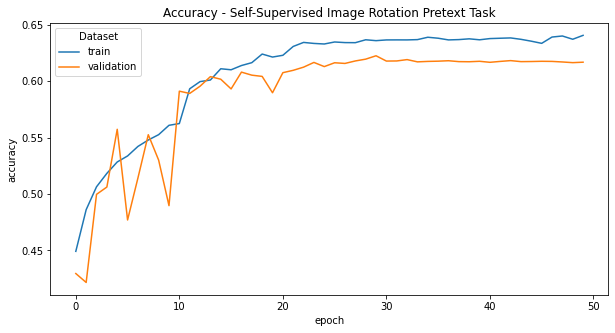

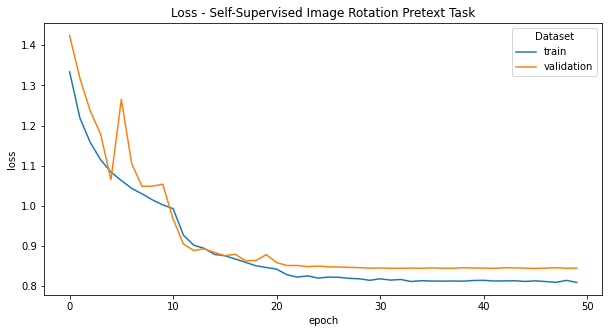

In [ ]:
with open("/content/drive/My Drive/Colab Notebooks/Self-Supervised-Learning/Pre-text_Rotation/Restnetv1_SSL_Rotation.h5_history",'rb') as fp:
        history = pickle.load(fp)

ssl_df = pd.DataFrame({'loss':history['loss'] + history['val_loss'], 'accuracy':history['accuracy'] + history['val_accuracy'], 'Dataset':'train'})
ssl_df.loc[len(ssl_df)//2:,'Dataset'] = 'validation'
ssl_df['epoch'] = np.concatenate((np.arange(len(history['loss'])),np.arange(len(history['loss']))))

figure = plt.figure(figsize=(10,5))
g = sns.lineplot(y='accuracy',x='epoch',hue='Dataset',data=ssl_df)
g.set_title('Accuracy - Self-Supervised Image Rotation Pretext Task')

figure = plt.figure(figsize=(10,5))
g = sns.lineplot(y='loss',x='epoch',hue='Dataset',data=ssl_df)
g.set_title('Loss - Self-Supervised Image Rotation Pretext Task')

In [ ]:
def train_models_datasplit(x_train, y_train, x_test, y_test,
                           batch_size = 128, epochs=50, data_augmentation=True,
                           num_classes=10,
                           n = 3, ssl_path=None, dataset='cifar10', input_shape=(32,32,3),
                           data_fraction_increment=0.1, num_increments=10, random_state=689):
     
    ### Calcualte number of many kfolds splits - 10
    n_splits = int(1/data_fraction_increment)
        
    # Convert class vectors to binary class matrices.
    y_test = keras.utils.to_categorical(y_test, num_classes)

    # Computed depth from supplied model parameter n
    depth = n * 6 + 2

    # Model name, depth and version
    model_type = 'ResNet%d' % depth
    
    ## Ensure that data increments consist of class balanced data
    skf = StratifiedKFold(n_splits = n_splits, random_state = random_state)
    
    histories = []
    for i,index  in enumerate(skf.split(x_train, y=y_train)):
        print("Training number: {}".format(i))
        if i > num_increments-1:
            break
        if i > 0:
            test_index = np.concatenate((test_index, index[1]))
        else:
            test_index = index[1]

        y_train_t = keras.utils.to_categorical(y_train, num_classes)[test_index]
        
        # if doing SSL method or not
        if ssl_path:
            # take already pretrained model
            ssl_model = keras.models.load_model(ssl_path)
            x = model = ssl_model.layers[-2].output # take model but without last layer
            x = Dense(10, activation='softmax')(x)  # replace that last layer with new for 10 neurons - 10 classes for dataset
            model = keras.Model(ssl_model.inputs,x)
        else:
            # take resnet_v1
            model = resnet_v1(input_shape=input_shape, depth=depth)
        
        # compile model - does not matter if it is SSL or not
        model.compile(loss ='categorical_crossentropy',
                      optimizer = Adam(learning_rate=lr_schedule(0)),
                      metrics = ['accuracy'])
        
        #model.summary()
        print(model_type)
        
        # Prepare model model saving directory.
        save_dir = os.path.join(os.getcwd(), 'saved_models')
        model_name = dataset + '_%s_model.h5' % model_type +"_"+ str((i/n_splits)*100)
        
        if not os.path.isdir(save_dir):
            os.makedirs(save_dir)
        filepath = os.path.join(save_dir, model_name)
        
        # Prepare callbacks for model saving and for learning rate adjustment.
#         checkpoint = ModelCheckpoint(filepath=filepath,
#                                      monitor='val_loss',
#                                      verbose=1,
#                                      save_best_only=True)
        lr_scheduler = LearningRateScheduler(lr_schedule)
        lr_reducer = ReduceLROnPlateau(factor=np.sqrt(0.1),
                                       cooldown=0,
                                       patience=5,
                                       min_lr=0.5e-6)
        callbacks = [ lr_reducer, lr_scheduler]
        
        # Run training, with or without data augmentation.
        if not data_augmentation:
            print('Not using data augmentation.')
            model.fit(x_train, y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_data=(x_test, y_test),
                      shuffle=True,
                      callbacks=callbacks)
        else:
            print('Using real-time data augmentation.')
            datagen = ImageDataGenerator(               # This will do preprocessing and realtime data augmentation:
                featurewise_center=False,               # set input mean to 0 over the dataset
                samplewise_center=False,                # set each sample mean to 0
                featurewise_std_normalization=False,    # divide inputs by std of dataset
                samplewise_std_normalization=False,     # divide each input by its std
                zca_whitening=False,                    # apply ZCA whitening
                zca_epsilon=1e-06,                      # epsilon for ZCA whitening
                rotation_range=0,                       # randomly rotate images in the range (deg 0 to 180)
                width_shift_range=0.1,                  # randomly shift images horizontally
                height_shift_range=0.1,                 # randomly shift images vertically
                shear_range=0.,                         # set range for random shear
                zoom_range=0.,                          # set range for random zoom
                channel_shift_range=0.,                 # set range for random channel shifts
                fill_mode='nearest',                    # set mode for filling points outside the input boundaries
                cval=0.,                                # value used for fill_mode = "constant"
                horizontal_flip=True,                   # randomly flip images
                vertical_flip=False,                    # randomly flip images
                rescale=None,                           # set rescaling factor (applied before any other transformation)
                preprocessing_function=None,            # set function that will be applied on each input
                data_format=None,                       # image data format, either "channels_first" or "channels_last"
                validation_split=0)                     # fraction of images reserved for validation (strictly between 0 and 1)
            
            # Compute quantities required for featurewise normalization
            # (std, mean, and principal components if ZCA whitening is applied).
            datagen.fit(x_train)
           
            # Fit the model on the batches generated by datagen.flow().
            histories.append(model.fit_generator(datagen.flow(x_train[test_index], y_train_t, batch_size=batch_size),
                             epochs=epochs, verbose=1, workers=4, validation_data=(x_test,y_test),
                             callbacks=callbacks))
            
        # Record performance of trained model into csv files for later plotting
        train_maxes = []
        val_maxes = []
        val_loss = []
        train_loss = []
        path_csv = '/content/drive/My Drive/Colab Notebooks/Self-Supervised-Learning/Pre-text_Rotation/'
        
        if ssl_path:
            print(" -- PATH: self_supervised")
            record_path = path_csv +'_self_supervised.csv'
        else:
            print(" -- PATH: supervised")
            record_path = path_csv +'_supervised.csv'

        for i in range(len(histories)):
            val_maxes.append(max(histories[i].history['val_accuracy']))
            train_maxes.append(max(histories[i].history['accuracy']))
            val_loss.append(min(histories[i].history['val_loss']))
            train_loss.append(min(histories[i].history['loss']))

        print(" -- write into csv file")
        pd.DataFrame({'Val_Accuracy':val_maxes,
                      'Train_Accuracy':train_maxes,
                      'Val_Loss':val_loss,
                      'Train_Loss':train_loss}).to_csv(record_path)

In [ ]:
### Run experiment WITHOUT self-supervision

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, y_train, x_test, y_test = preprocess_data2(x_train, y_train, x_test, y_test)
train_models_datasplit(x_train, y_train, x_test, y_test, data_fraction_increment=0.02, batch_size=32, num_increments=10, dataset='CIFAR10_large')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Num of trainings: 0
Learning rate:  0.001
ResNet20
Using real-time data augmentation.
Learning rate:  0.001
Epoch 1/50
32/32 [==============================] - 3s 84ms/step - loss: 3.0254 - accuracy: 0.1980 - val_loss: 18.2566 - val_accuracy: 0.0902
Learning rate:  0.001
Epoch 2/50
32/32 [==============================] - 2s 62ms/step - loss: 2.0876 - accuracy: 0.2980 - val_loss: 4.7409 - val_accuracy: 0.1230
Learning rate:  0.001
Epoch 3/50
32/32 [==============================] - 2s 62ms/step - loss: 1.8999 - accuracy: 0.3470 - val_loss: 2.6003 - val_accuracy: 0.2149
Learning rate:  0.001
Epoch 4/50
32/32 [==============================] - 2s 61ms/step - loss: 1.8574 - accuracy: 0.3530 - val_loss: 2.4829 - val_accuracy: 0.2513
Learning rate:  0.001
Epoch 5/50
32/32 [==============================] - 2s 62ms/step - loss: 1.7708 - accuracy: 0.4000 - val_loss: 2.5462 - val_accuracy: 0.2588
Learning rate:  0.001
Epoch 6/50
32/32 [==============================] - 2s 61ms/step - loss: 1.7

In [ ]:
### Run experiment with WITH self-supervision

(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train, y_train, x_test, y_test = preprocess_data2(x_train, y_train, x_test, y_test)
train_models_datasplit(x_train, y_train, x_test, y_test, data_fraction_increment=0.02, batch_size=32, num_increments=10, dataset='CIFAR10_large', ssl_path='/content/drive/My Drive/Colab Notebooks/Self-Supervised-Learning/Pre-text_Rotation/Restnetv1_SSL_Rotation.h5')

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


Num of trainings: 0
Learning rate:  0.001
ResNet20
Using real-time data augmentation.
Learning rate:  0.001
Epoch 1/50
32/32 [==============================] - 3s 79ms/step - loss: 1.9387 - accuracy: 0.3310 - val_loss: 7.6877 - val_accuracy: 0.1881
Learning rate:  0.001
Epoch 2/50
32/32 [==============================] - 2s 61ms/step - loss: 1.4788 - accuracy: 0.5010 - val_loss: 4.8164 - val_accuracy: 0.2377
Learning rate:  0.001
Epoch 3/50
32/32 [==============================] - 2s 60ms/step - loss: 1.3578 - accuracy: 0.5410 - val_loss: 2.6058 - val_accuracy: 0.3803
Learning rate:  0.001
Epoch 4/50
32/32 [==============================] - 2s 62ms/step - loss: 1.2541 - accuracy: 0.5890 - val_loss: 2.8752 - val_accuracy: 0.3415
Learning rate:  0.001
Epoch 5/50
32/32 [==============================] - 2s 60ms/step - loss: 1.1562 - accuracy: 0.6120 - val_loss: 2.2640 - val_accuracy: 0.4312
Learning rate:  0.001
Epoch 6/50
32/32 [==============================] - 2s 60ms/step - loss: 1.05

In [ ]:
def plot_ssl_vs_sl(df_ssl, df_sl, data_increment=0.1):
    #df_sl = pd.read_csv('cifar10_large' +'_supervised.csv')
    #df_ssl = pd.read_csv('cifar10_large' +'_ssl.csv')
    df_sl['Model_Type']='Only_Supervised'
    df = pd.concat((df_sl,df_ssl))
    df['Model_Type'][len(df_ssl):]='Self_Supervised'
    df['Number_of_Samples'] = (df['Unnamed: 0']+1) *50000*data_increment
    df['Test_Accuracy'] = df['Val_Accuracy']
    
    figure = plt.figure(figsize=(10,5))
    g = sns.lineplot(y='Test_Accuracy',x='Number_of_Samples',hue='Model_Type',data=df)
    title='Accuracy Self-Supervised vs Only Supervised'
    g.set_title(title)
    
    figure = plt.figure(figsize=(10,5))
    f = sns.lineplot(y='Val_Loss',x='Number_of_Samples',hue='Model_Type',data=df)
    title='Loss Self-Supervised vs Only Supervised'
    f.set_title(title)
    plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


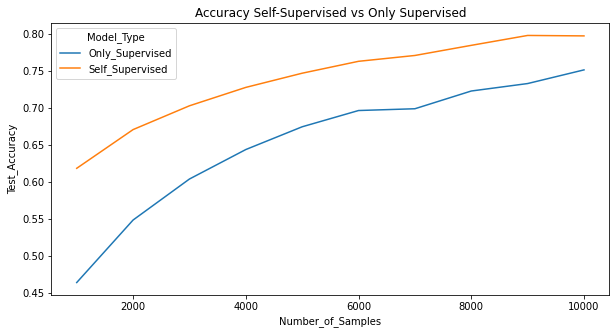

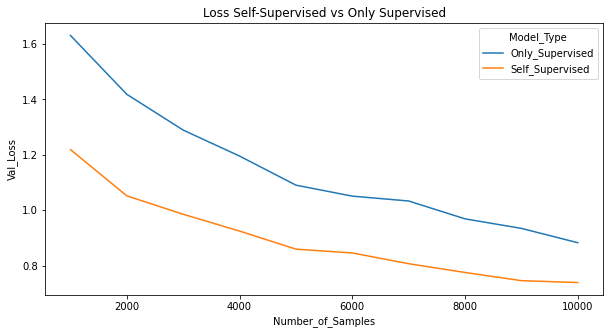

In [ ]:
df_sl = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Self-Supervised-Learning/Pre-text_Rotation/_supervised.csv')
df_ssl = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Self-Supervised-Learning/Pre-text_Rotation/_self_supervised.csv')

plot_ssl_vs_sl(df_ssl,df_sl,data_increment=0.02 )